In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sympy as sp
import at
import math
from tqdm import tqdm

# Selfmade files
from functions import *
from PID import *

# Import ring information
from rings.p3_elements_v24_c4l import *
# ring = load_mat('rings/hmba.mat')

In [2]:
# Lattice creation
lat = at.Lattice(ring, energy=6.e9)
lat.radiation_off()

lat2 = at.Lattice(ring, energy=6.e9)
lat2.radiation_off() 

# Obtaining Ids
cor_ids = at.get_refpts(lat, at.elements.Corrector)
bpm_ids = at.get_refpts(lat, at.elements.Monitor)
quad_ids = at.get_refpts(lat, at.elements.Quadrupole)

# BPMs positions
s_pos = lat.get_s_pos(bpm_ids)

Ring model:

$ y(t) = R_m \cdot \Delta q_i(t) + R_c \cdot \Delta \theta_i(t - \Delta t) $


In [3]:
dkick = 0.0001
offset = 0.0001
Rm, Rc = response_matrices(lat, dkick, offset, 1)

In [4]:
def spectrum_noise(spectrum_func, samples=1024, rate=44100):
    freqs = np.fft.rfftfreq(samples, 1.0/rate)            # real-fft frequencies (not the negative ones)
    spectrum = np.zeros_like(freqs, dtype='complex')      # make complex numbers for spectrum
    spectrum[1:] = spectrum_func(freqs[1:])               # get spectrum amplitude for all frequencies except f=0
    phases = np.random.uniform(0, 2*np.pi, len(freqs)-1)  # random phases for all frequencies except f=0
    spectrum[1:] *= np.exp(1j*phases)                     # apply random phases
    noise = np.fft.irfft(spectrum)                        # return the reverse fourier transform
    noise = np.pad(noise, (0, samples - len(noise)), 'constant') # add zero for odd number of input samples
 
    return noise
 
def pink_spectrum(f, f_min=0, f_max=np.inf, att=np.log10(2.0)*10):
    s = f**-( 0.5 * (att/10.0) / np.log10(2.0) )  # apply attenuation
    s[np.logical_or(f < f_min, f > f_max)] = 0    # apply band pass
    return s

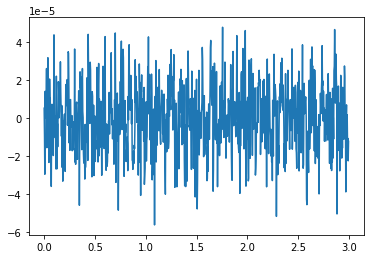

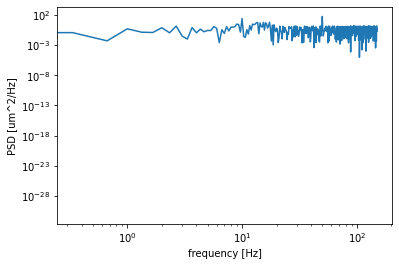

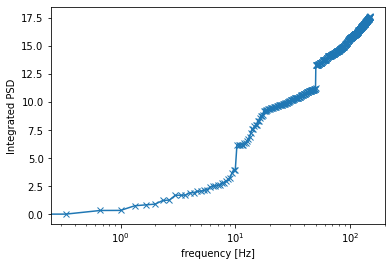

In [8]:
# Time configuration 
f_turn = 130435
fs = 300
ts = 1/fs
t_max = 3
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)
freqs = np.fft.fftfreq(N, 1/fs)

# Perturbations

# fmin=1e-6
# fmax=1
# perturbation_samples = sinesweep(t, fmin, fmax, amplitude = 0.0001)

# ******

perturbation_samples = real_perturbation(t) * 1e-5

# ******

# fsin = 1
# amplitude = 0.00001
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin) + amplitude*np.sin(2*np.pi*t*fsin*70)

# ******

# t0 = 0.1
# perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.00001])

# ******

# import colorednoise as cn

# beta = 2 # the exponent
# samples = N # number of samples to generate
# perturbation_samples = cn.powerlaw_psd_gaussian(beta, samples) * 10e-6

# ******

# perturbation_samples = spectrum_noise(lambda x:pink_spectrum(x, 0, 1000), N, fs) * 10e-6
# perturbation_samples = spectrum_noise(lambda f: 1 / f**4, N, fs) * 10e-6

# ******

plt.plot(t, perturbation_samples)
plt.figure()
plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * perturbation_samples)/N))**2))[:N//2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [um^2/Hz]')

plt.figure()

aux = []
for f in range(0, N//2):
    aux.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((1e6 * perturbation_samples)/N))**2))[:f])))
plt.plot(freqs[:N//2], aux, 'x-')
plt.xlabel('frequency [Hz]')
plt.ylabel('Integrated PSD')
plt.xscale('log')

In [18]:
%matplotlib inline

# TRANSFER FUNCTIONS
# Low pass filter 
# wc = 2 * np.pi * 10
# num_lp = [wc]
# den_lp = [1, wc]
wc = 2 * np.pi * 720
num_lp = [1]
den_lp = [1/wc**2, 1.4142/wc, 1]

# PID controller
Kp = 0.5
Ki = 0.1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
orbit_wc = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
rms_wc = []
x_lp = np.zeros(len(bpm_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(cor_ids)*(len(den_pid)-1))

# Delay configuration
# loop_delay = 0
loop_delay = 3e-6
# loop_delay = 131e-6
delay_offset = math.ceil(loop_delay*fs) 
print(delay_offset)

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# TEMPORAL TO DELETE
mov = []
rec = []

# Simulation
for n in tqdm(range(1, t.size)):
    # Error calculation
    error[n, :] = reference_orbit - orbit[n-1, :]

    # Correctors str
    corr_str[n, :] = np.dot(Rcinv.T, filter_out)

    # PID controller
    corr_str[n, :], x_pid = apply_f(num_pid, den_pid, corr_str[n, :], x_pid, ts)

    # Correctors response
    if n >= delay_offset:
        corr_str_delay[n, :] = corr_str[n - delay_offset, :]

    # Low-pass filter
    filter_out, x_lp = apply_f(num_lp, den_lp, corr_str_delay[n, :] , x_lp, ts)

    # Adding perturbation 
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]
   
    # Orbit calculation
    orbit_wc[n, :] = np.dot(Rm.T, quad_offset[n, :]) 
    orbit[n, :] = np.dot(Rm.T, quad_offset[n, :]) + np.dot(Rc.T,  filter_out)
    
    mov.append(np.dot(Rm.T, quad_offset[n, :]) [0])
    rec.append(np.dot(Rc.T, corr_str_delay[n, :])[0])
    rms_wc.append(np.sqrt(np.mean(np.square(orbit_wc[n, :]))))
    rms.append(np.sqrt(np.mean(np.square(orbit[n, :]))))

1


100%|██████████| 899/899 [03:31<00:00,  4.24it/s]


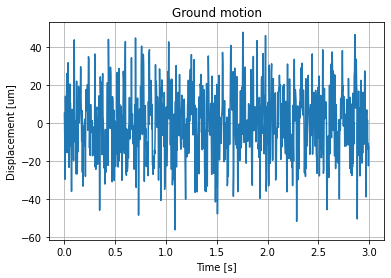

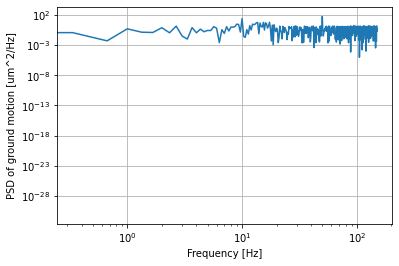

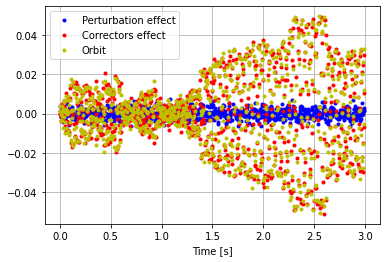

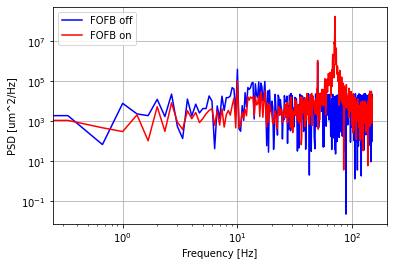

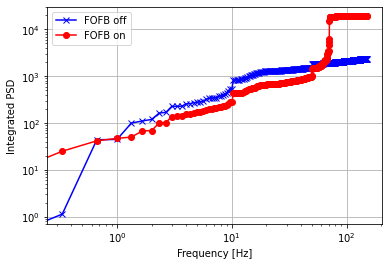

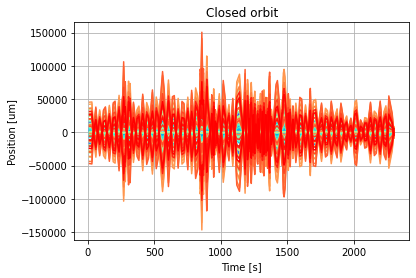

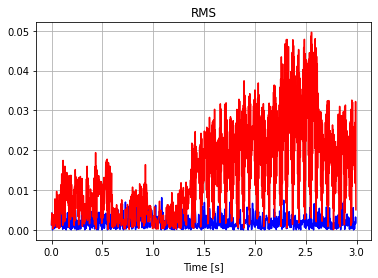

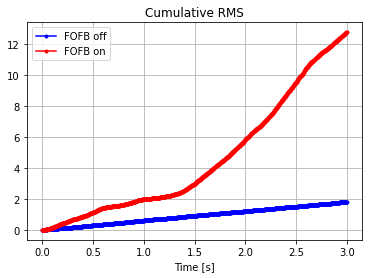

In [17]:
# Plotting
plt.plot(t, perturbation_samples[:] * 1e6)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [um]')
plt.title('Ground motion')
plt.grid()

plt.figure()

plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * perturbation_samples)/N))**2))[:N//2])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD of ground motion [um^2/Hz]')
plt.grid()

plt.figure()

plt.plot(t[:len(t)-1], mov[:], 'b.', label="Perturbation effect")
plt.plot(t[:len(t)-1], rec[:], 'r.', label="Correctors effect")
res = np.zeros(len(mov))
for i in range(0, len(mov)):
    res[i] = mov[i] + rec[i]
plt.plot(t[:len(t)-1], res[:], 'y.', label="Orbit")
plt.xlabel('Time [s]')
plt.legend()
plt.grid()

plt.figure()

plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * orbit_wc[:, 0])/N))**2))[:N//2], 'b-', label="FOFB off")
plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * orbit[:, 0])/N))**2))[:N//2], 'r-', label="FOFB on")
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [um^2/Hz]')
plt.legend()
plt.grid()

plt.figure()

aux = []
aux2 = []
for f in range(0, N//2):
    aux.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((1e6 * orbit_wc[:, 0])/N))**2))[:f])))
    aux2.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((1e6 * orbit[:, 0])/N))**2))[:f])))
plt.loglog(freqs[:N//2], aux, 'bx-', label="FOFB off")
plt.loglog(freqs[:N//2], aux2, 'ro-', label="FOFB on")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Integrated PSD')
plt.xscale('log')
plt.legend()
plt.grid()

plt.figure()

color = iter(plt.cm.rainbow(np.linspace(0, 1, int(t.size/10))))
for n in range(1, t.size):
    if n%10 == 1:
        c = next(color)
        plt.plot(s_pos, 1e6 * orbit[n, :], c=c, label=n)
# plt.legend(loc='best')
plt.ylabel('Position [um]')
plt.xlabel('Time [s]')
plt.title('Closed orbit')
plt.grid()

plt.figure()

plt.plot(t[:len(t)-1], rms_wc, 'b-', label="FOFB off")
plt.plot(t[:len(t)-1], rms, 'r-', label="FOFB on")
plt.xlabel('Time [s]')
plt.title('RMS')
plt.grid()

plt.figure()

au = []
au_wc = []
for cont in range(0, t.size):
    au_wc.append(np.sum(rms_wc[:cont]))
    au.append(np.sum(rms[:cont]))
plt.plot(t, au_wc, 'b.-', label="FOFB off")
plt.plot(t, au, 'r.-', label="FOFB on")
plt.xlabel('Time [s]')
plt.legend()
plt.title('Cumulative RMS')
plt.grid()

# ****************************************************************

In [ ]:
# ts = 1/150
# wc = 2 * np.pi * 715
# num = [wc]
# den = [1, wc]
Kp = 1
Ki = 1
Kd = 2
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

wc = 2 * np.pi * 30
num_lp = [wc]
den_lp = [1, wc]
    
sys = signal.TransferFunction(num_lp, den_lp)

w , mag, phase = signal.bode(sys)
plt.plot(w, mag)
plt.figure()
plt.plot(w, phase)

In [ ]:
%matplotlib inline

# Time configuration 
fs = 150
ts = 1/fs
t_max = 3
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)

# Perturbations
# perturbation_samples = spectrum_noise(lambda f: 1 / f**0, N, fs) 

# fmin=1e-3
# fmax=75
# perturbation_samples = sinesweep(t, fmin, fmax)

# fsin = 10
# amplitude = 1
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

t0 = 0.1
perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.0001])

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 200
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
quad_offset2 = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
x_lp = np.zeros(len(quad_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(bpm_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs) 

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# Simulation
for n in tqdm(range(1, t.size)):
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]
    quad_offset2[n, :], x_lp = apply_f(num_lp, den_lp, quad_offset[n, :], x_lp, ts)

freqs = np.fft.fftfreq(N, 1/fs)
plt.plot(freqs[:N//2], np.abs(np.fft.fft(perturbation_samples))[:N//2]*(2/len(perturbation_samples)))
plt.xlabel('Frequency [Hz]')
plt.title('Perturbation PSD')

plt.figure()

plt.plot(freqs[:N//2], np.abs(np.fft.fft(quad_offset2[:, 0]))[:N//2]*(2/len(quad_offset2[:, 0])))
plt.xlabel('Frequency [Hz]')
plt.title('Error PSD in element 0')

In [ ]:
def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    plt.loglog(f, np.abs(np.fft.rfft(s)))

def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N))
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S
        return np.fft.irfft(X_shaped)

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

plt.figure(figsize=(8, 8))
for G in [pink_noise]:
    plot_spectrum(G(2**14))
plt.ylim([1e-3, None])

In [ ]:
quad_offset = np.zeros((t.size, len(quad_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))

# Inverse of reponse matrix 
# n_sv = 80
# Rcinv = svd_solve(Rc, n_sv)

# quad_offset[0, :] = quad_offset[0, :] + perturbation_samples[100]
# orbit[0, :] = np.dot(Rm.T, quad_offset[0, :]) 

# corr_str[0, :] = np.dot(Rcinv.T, -1 * orbit[0, :])

# quad_offset[1, :] = quad_offset[1, :] + perturbation_samples[100]
# orbit[0, :] = np.dot(Rm.T, quad_offset[1, :])
# plt.plot(orbit[0, :], 'b.-')

# orbit[0, :] = orbit[0, :] + np.dot(Rc.T, corr_str[0, :]) 
# plt.plot(orbit[0, :], 'r.-')

wc = 2 * np.pi * 10
num_lp = [1]
den_lp = [1/wc**2, 1.4142/wc, 1]
orbit2 = np.zeros((t.size, len(bpm_ids)))
x_lp = np.zeros(len(bpm_ids)*(len(den_lp)-1))

for a in range(0, t.size):
    orbit[a, :], x_lp = apply_f(num_lp, den_lp, np.dot(Rm.T, quad_offset[a, :] + perturbation_samples[a]), x_lp, ts)
    orbit2[a, :] = np.dot(Rm.T, quad_offset[a, :] + perturbation_samples[a])

plt.plot(t, orbit2[:, 0], 'b.-')
plt.plot(t, orbit[:, 0], 'r.-')